# DSCI 100 Project: Individual planning stage

**By Angel Chen (71703029) of Group 4 from DSCI 100 – section 008**

In [1]:
library(repr)
library(tidyverse)
options(repr.matrix.max.rows = 4)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


The questions:
> Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
> 
> Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
> 
> Question 3: We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 

Let's first have a look at the data.

In [2]:
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Within the `players` dataset, we can see certain characteristics of each participant who has signed up to PLAICraft.ai. There are 196 observations and 7 variables. The variables are summarized by the following table:

|Variable|Data type|Explanation|
|--------|--------|--------|
|`experience`|character|Player's self-identified Minecraft experience level|
|`subscribe`|logical|Player's subscription to newsletter (true if subscribed)|
|`hashedEmail`|character|Player's email address hidden as a hash|
|`played_hours`|double|Total hours of Minecraft played via the plaicraft.ai server|
|`name`|character|Player's submitted name|
|`gender`|character|Player's self-identified gender|
|`Age`|double|Player's submitted age|

From the get-go, we can see that certain variables' data types aren't optimal. Namely, for categorical variables with a limited selection of values like `experience` and `gender`, the data type should be changed to factor.

In [3]:
players <- players |>
    mutate(
        experience = as_factor(experience),
        gender = as_factor(gender)
    )
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Done! Let's do a summary overview of the data.

In [4]:
summary(players)

    experience subscribe       hashedEmail         played_hours    
 Pro     :14   Mode :logical   Length:196         Min.   :  0.000  
 Veteran :48   FALSE:52        Class :character   1st Qu.:  0.000  
 Amateur :63   TRUE :144       Mode  :character   Median :  0.100  
 Regular :36                                      Mean   :  5.846  
 Beginner:35                                      3rd Qu.:  0.600  
                                                  Max.   :223.100  
                                                                   
     name                         gender         Age       
 Length:196         Male             :124   Min.   : 9.00  
 Class :character   Female           : 37   1st Qu.:17.00  
 Mode  :character   Non-binary       : 15   Median :19.00  
                    Prefer not to say: 11   Mean   :21.14  
                    Agender          :  2   3rd Qu.:22.75  
                    Two-Spirited     :  6   Max.   :58.00  
                    Other           

Concerning the quantitative variables in `players`,

|Variable|Range (min. to max. value)|Median|Mean|
|--------|--------|--------|--------|
|`played_hours`|0.00 to 223.10|0.10|5.85|
|`Age`|9 to 58|19|21.13|

Within the `Age` variable, there are also 2 `NA`'s, which we will need to account for in our downstream data analysis. It is concerning that the median played hours is 0.10, which reveals that half of players who have signed up to PLAICraft.ai have played less than 0.10 hours. As the dataset includes all participants who have signed up but not necessarily played, players who have `played_hours` values of 0 may not be useful to our analysis if we want to answer Questions 2 or 3.

Concerning the non-quantitative variables,
* `experience` Experience levels have the options ranging from Beginner, Amateur, Regular, Veteran, Pro. From reading the blog on PLAICraft.ai, we learn that these experience levels are self-identified by the participants. The problem, however, is that this variable is clearly an ordinal categorical variable, but there is no indication from the researcher's site concerning the order of experience level. Is "Veteran" more experienced than "Pro"? We do not know.
* `subscribe` In this variable, the value is `TRUE` if the participant has subscribed to a game-related newsletter, `FALSE` otherwise. However, we have no information on what this newsletter is. Is this newsletter provided by the research team? Is it related to PLAICraft.ai and Minecraft content, or is it about video games in general? We also do not know if this is self-reported from the participants or data from the researchers. If it is the latter, then the newsletter is provided by the research team.
* `hashedEmail` The 64-digit hash of the players' emails includes a unique and random combination and order of arabic numbers and alphabetical letters.
* `name` The player's submitted name for researchers to refer to them with more ease rather than a bunch of hashes. Players can also see each other's names in-game to facilitate easy communication.
* `gender` The self-identified gender is limited to the options of Male, Female, Non-binary, Agender, Two-Spirited, Other, and Prefer not to say.

Now, let's have a look at the other dataset.

In [5]:
options(scipen = 999)
sessions <- read_csv("data/sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1719770000000,1719770000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1718670000000,1718670000000
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1721890000000,1721890000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1716170000000,1716170000000


Within the `sessions` dataset, each observation (row) is an instance of a participant's uninterrupted Minecraft gaming session on PLAICraft.ai. Players are identified by their unique `hashedEmail`, and players who play on PLAICraft.ai for more than one session would have more than one observation in this dataset.

|Variable|Data type|Explanation
|--------|--------|--------|
|`hashedEmail`|character|Player's email address hidden as a 64-digit hash|
|`start_time`|double|GMT dd/mm/yyyy and 24-hour time at which player began playing session|
|`end_time`|double|GMT dd/mm/yyyy and 24-hourtime at which player ended playing session|
|`original_start_time`|double|GMT Unix timestamp at which player began playing session|
|`original_end_time`|double|GMT Unix timestamp at which player ended playing session|

The Unix Epoch timestamps include milliseconds (therefore 13 digits) and is in GMT. The same goes for `start_time` and `end_time`. A primary concern with the `original_start_time` and `original_end_time` variables is that the last 7 digits are omitted (written as 0). The last 3 digits represent the milliseconds, which do not matter. However, the preceding 4 digits represent the minutes and hours (one hour is 3600 seconds). The fact that these digits are omitted to 0 means that we will not see any change in the Unix timestamp between `original_start_time` and `original_end_time` unless the uninterrupted gaming session exceeds 24 hours, which did not occur in this dataset. These two variables are therefore not useful for downstream application.

For ease of use with `start_time` and `end_time`, the data type will be changed from character to datetime.

In [6]:
sessions1 <- sessions |>
    separate(
        start_time, c("start_date", "start_time"), sep = " "
    ) |>
    mutate(
        start_date = as.POSIXct(start_date, format = "%d/%m/%Y", tz = "GMT"),
        start_time = as.POSIXct(start_time, format = "%H:%M", tz = "GMT"),
        end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M", tz = "GMT")
    )

# IF ANY OF THE DTTM VARIABLES RETURN `NA`, PLEASE RESTART KERNEL AND RERUN THE CELLS.
as.POSIXlt("30/06/2024 18:24", format = "%d/%m/%Y %H:%M", tz = "GMT")

# POSIXct stores stuff in chronological order according to UNIX time
# I want POSIXlt because I want to graph the hours irregardless of the date...
# But ggplot works much better with POSIXct...

# Unless I just convert the hours to decimals rather than H:M
sessions1

[1] "2024-06-30 18:24:00 GMT"

hashedEmail,start_date,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30,2025-11-13 18:12:00,2024-06-30 18:24:00,1719770000000,1719770000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17,2025-11-13 23:33:00,2024-06-17 23:46:00,1718670000000,1718670000000
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25,2025-11-13 06:15:00,2024-07-25 06:22:00,1721890000000,1721890000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20,2025-11-13 02:26:00,2024-05-20 02:45:00,1716170000000,1716170000000


In [7]:
sessions2 <- sessions |>
    separate(start_time, c("start_date", "start_time"), sep = " ") |>    
    separate(start_time, c("hour", "minute"), sep = ":")

sessions3 <- sessions2 |>
    mutate(minute = as.double(minute)) |>
    mutate(minute = minute / 60) |>
    mutate(hour = as.double(hour)) |>
    mutate(hour_decimal = hour + minute) |>
    select(-hour, -minute)
    #transform(hour_decimal = paste0(hour, minute)) NVM I'M JUST SUPPOSED TO ADD THEM LMAOOOOOO
sessions3

arrange(sessions3, desc(hour_decimal))
filter(sessions3, hour_decimal == 0)

hashedEmail,start_date,end_time,original_start_time,original_end_time,hour_decimal
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,30/06/2024 18:24,1719770000000,1719770000000,18.20
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,17/06/2024 23:46,1718670000000,1718670000000,23.55
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024,25/07/2024 06:22,1721890000000,1721890000000,6.250000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024,20/05/2024 02:45,1716170000000,1716170000000,2.433333


hashedEmail,start_date,end_time,original_start_time,original_end_time,hour_decimal
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,28/06/2024,29/06/2024 02:14,1719620000000,1719630000000,23.98333
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,13/06/2024,14/06/2024 01:59,1718320000000,1718330000000,23.96667
⋮,⋮,⋮,⋮,⋮,⋮
a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,14/08/2024,14/08/2024 02:51,1723590000000,1723600000000,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,01/08/2024,01/08/2024 01:26,1722470000000,1722480000000,0


hashedEmail,start_date,end_time,original_start_time,original_end_time,hour_decimal
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,24/07/2024,24/07/2024 00:34,1721780000000,1721780000000,0
a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,14/08/2024,14/08/2024 02:51,1723590000000,1723600000000,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,01/08/2024,01/08/2024 01:26,1722470000000,1722480000000,0


In [8]:
?paste # o ts is for strings

paste {base},R Documentation
...,"one or more R objects, to be converted to character vectors."
sep,a character string to separate the terms. Not NA_character_.
collapse,"an optional character string to separate the results. Not NA_character_. When collapse is a string, the result is always a string (character of length 1)."
recycle0,"logical indicating if zero-length character arguments should result in the zero-length character(0). Note that when collapse is a string, recycle0 does not recycle to zero-length, but to """"."


In [9]:
summary(sessions)

 hashedEmail         start_time          end_time        
 Length:1535        Length:1535        Length:1535       
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
                                                         
 original_start_time     original_end_time      
 Min.   :1712400000000   Min.   :1712400000000  
 1st Qu.:1716240000000   1st Qu.:1716240000000  
 Median :1719200000000   Median :1719180000000  
 Mean   :1719201355050   Mean   :1719195949120  
 3rd Qu.:1721890000000   3rd Qu.:1721890000000  
 Max.   :1727330000000   Max.   :1727340000000  
                         NA's   :2              

We also see there are 2 `NA`'s within

In [10]:
players_summary <- players |>
    summarize(
        mean_played_hours = mean(played_hours),
        mean_age = mean(Age, na.rm = TRUE)
        )
players_summary

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


### Research question: Figuring out time windows with peak player activity
### What time of day are players the most active on PLAICraft.ai? Specific question: What are the demographics (age, gender, experience level) of these players? Can we predict the time of day a player is most likely to start a session on PLAICraft.ai based on their age, gender, and experience level?

How I'll go about answering this question:
* Remove players that have 0h playtime from `players.csv`
* First plot a histogram of the hours of the day that players are most frequent to start playing sessions
* Players that have >1 sessions, the time at which they start will be averaged, so each player would only have 1 entry
* And then combine the 2 datasets for predictive analysis

In [11]:
colSums(is.na(sessions))
filter(sessions, is.na(end_time))

hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
55d24216db39c27e1f17cc43d3127cbf8ed76ada6d098202b53ded319855e2c1,27/08/2024 17:06,NA,1724780000000,NA
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,15/09/2024 04:21,NA,1726370000000,NA


In [12]:
colSums(is.na(players))
filter(players, is.na(Age))

experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] "#1B9E77FF" "#D95F02FF" "#7570B3FF" "#E7298AFF" "#66A61EFF" "#E6AB02FF"
[7] "#A6761DFF" "#666666FF"

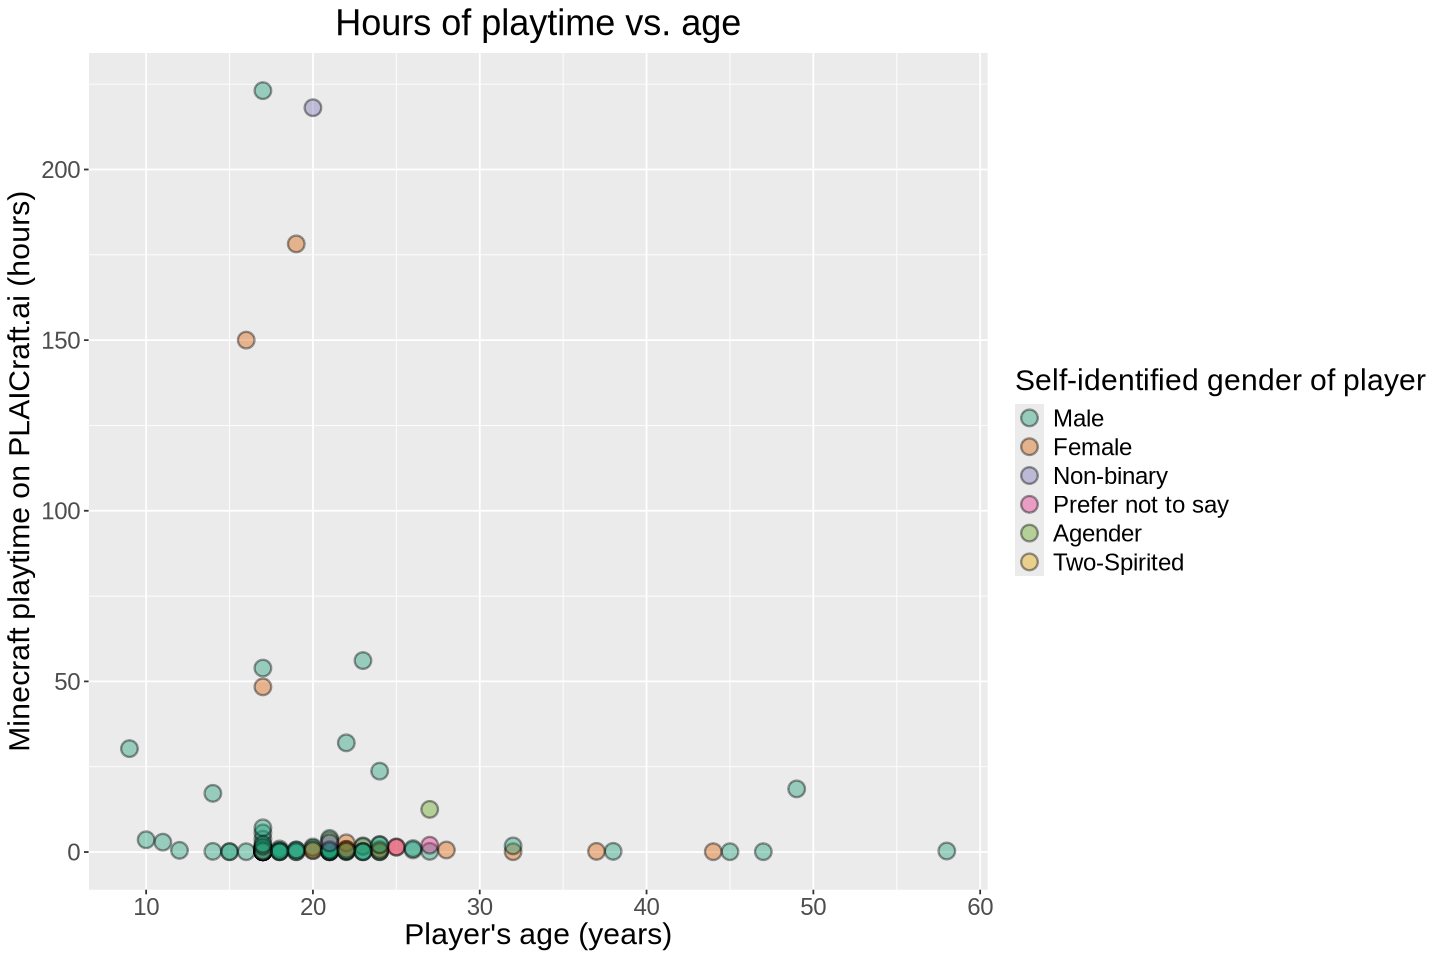

In [64]:
options(repr.plot.width = 12, repr.plot.height = 8)
c("#1B9E77FF", "#D95F02FF", "#7570B3FF", "#E7298AFF", "#66A61EFF", "#E6AB02FF", "#A6761DFF", "#666666FF")

hour_v_age <- na.omit(players) |> #There are 2 players with NA age
    filter(played_hours != 0) |>
    ggplot(aes(x = Age, y = played_hours, fill = gender)) +
        geom_point(alpha = 0.4, size = 4, stroke = 1, shape = 21) +
        labs(x = "Player's age (years)", y = "Minecraft playtime on PLAICraft.ai (hours)",
             fill = "Self-identified gender of player", title = "Hours of playtime vs. age") +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_colour_brewer(palette = "Dark2")
hour_v_age



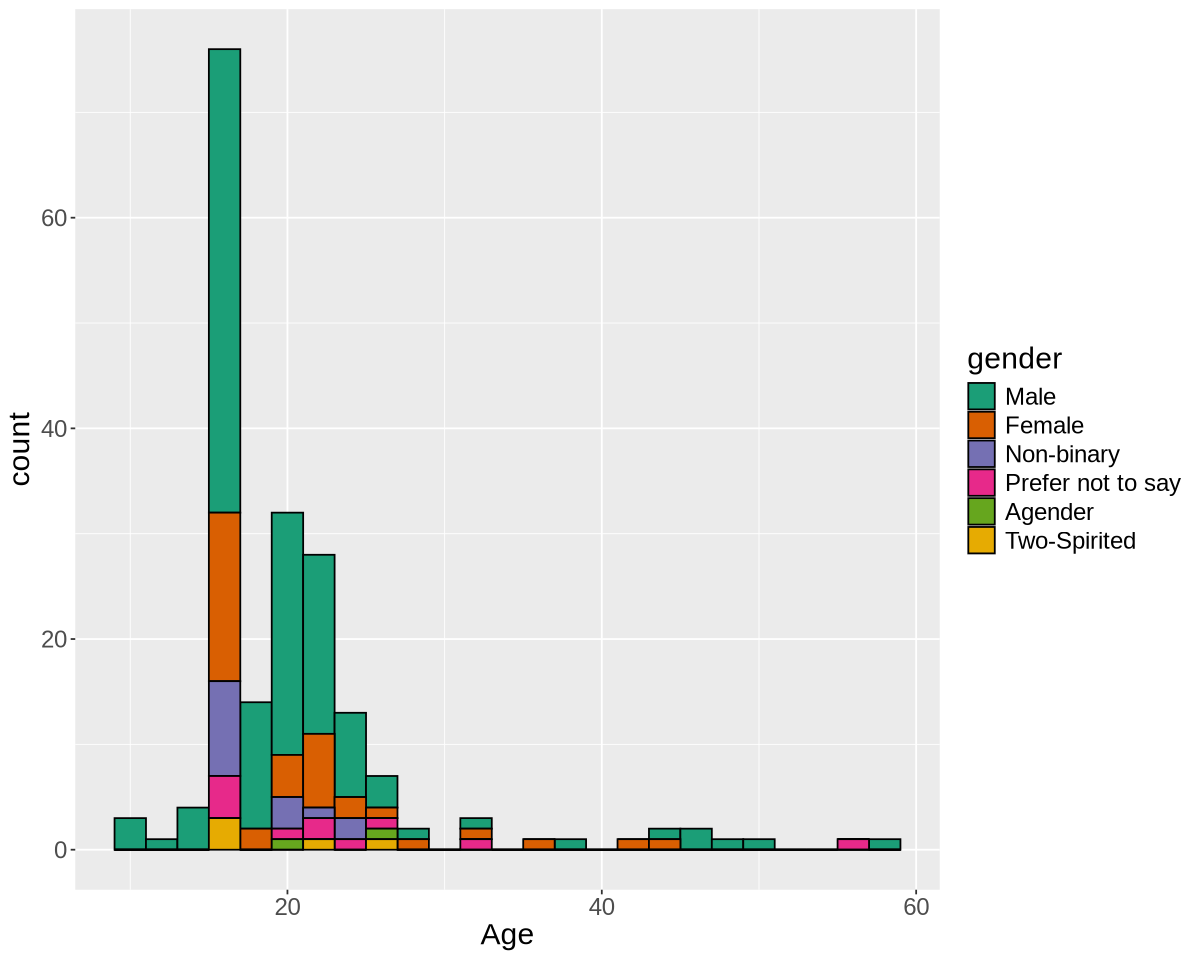

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)
player_age <- na.omit(players) |>
    ggplot(aes(Age, fill = gender)) +
        geom_histogram(binwidth = 2, colour = "black") +
        labs() +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
        scale_fill_brewer(palette = "Dark2")
player_age

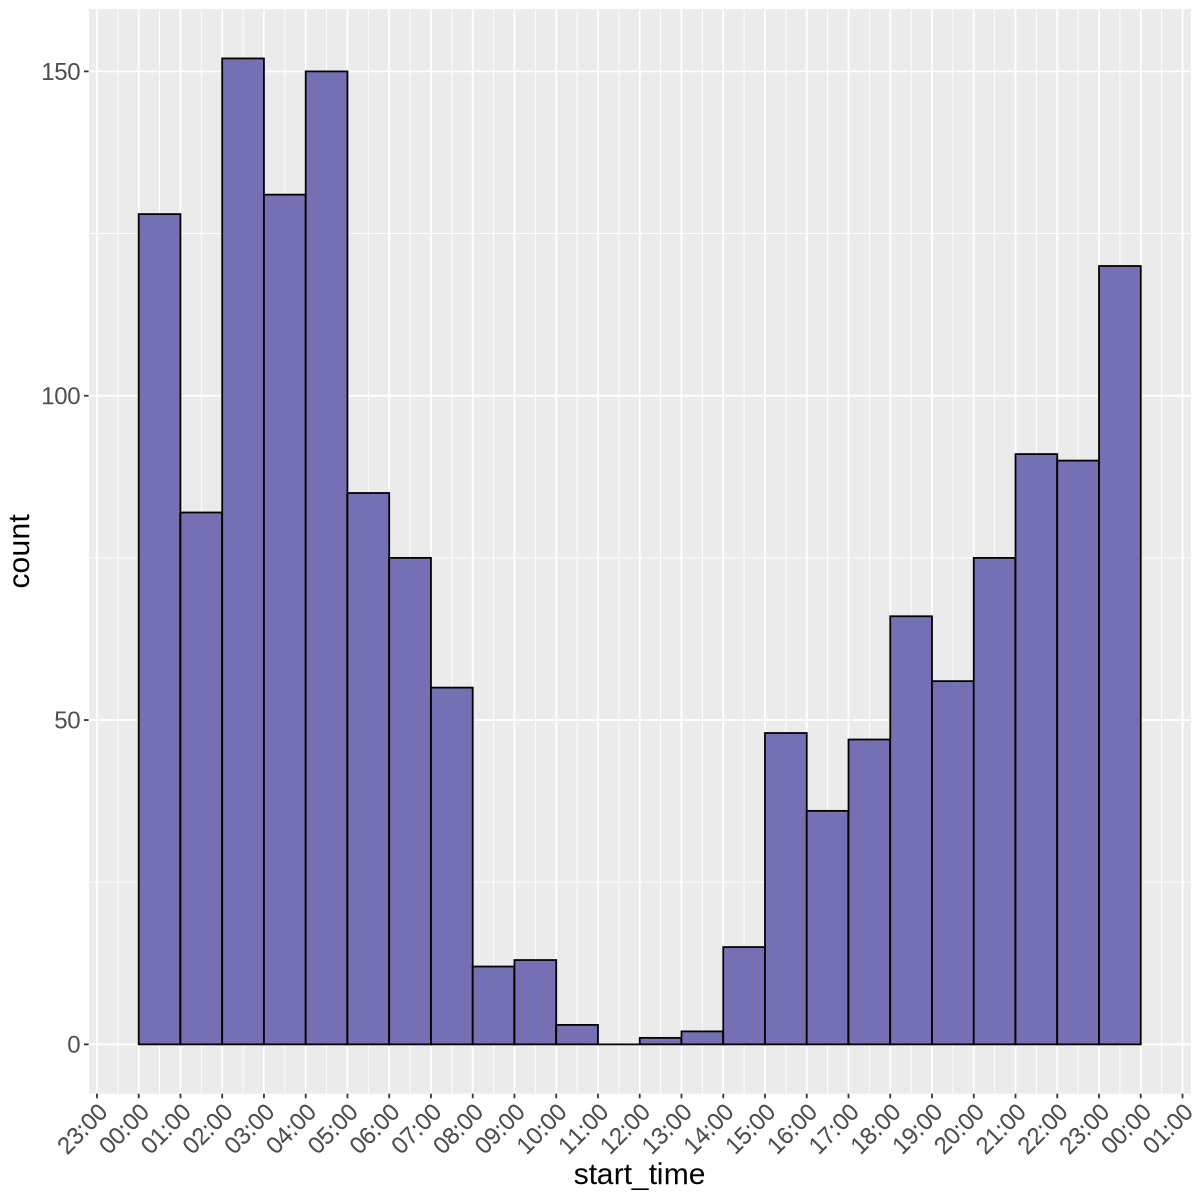

In [38]:
options(repr.plot.width = 10, repr.plot.height = 10)

colours_idk <- scale_fill_brewer(palette = "Dark2")

session1 <- na.omit(sessions1) |>
    ggplot(aes(start_time)) +
        geom_histogram(colour = "black", binwidth = 3600, boundary = 0, fill = "#7570B3FF") +
        scale_x_datetime(date_breaks = "1 hour", date_label = "%H:%M") +
        labs() +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5),
             axis.text.x = element_text(angle = 45, hjust = 1))
        #scale_fill_brewer(palette = "Dark2")
        #scale_x_continuous(n.breaks = 24)
session1
# Okay I see POSIXct directly plots UNIX timestamps <- also explains why the data is not the same as
# the graph using hour_decimal because we don't have that information HAIYAH
# but the dates/hours/minutes were converted from start_time into dttm tho? So it should be the same...??? WTF man
# Ok it's the same

# should i combine the 2 datasets?

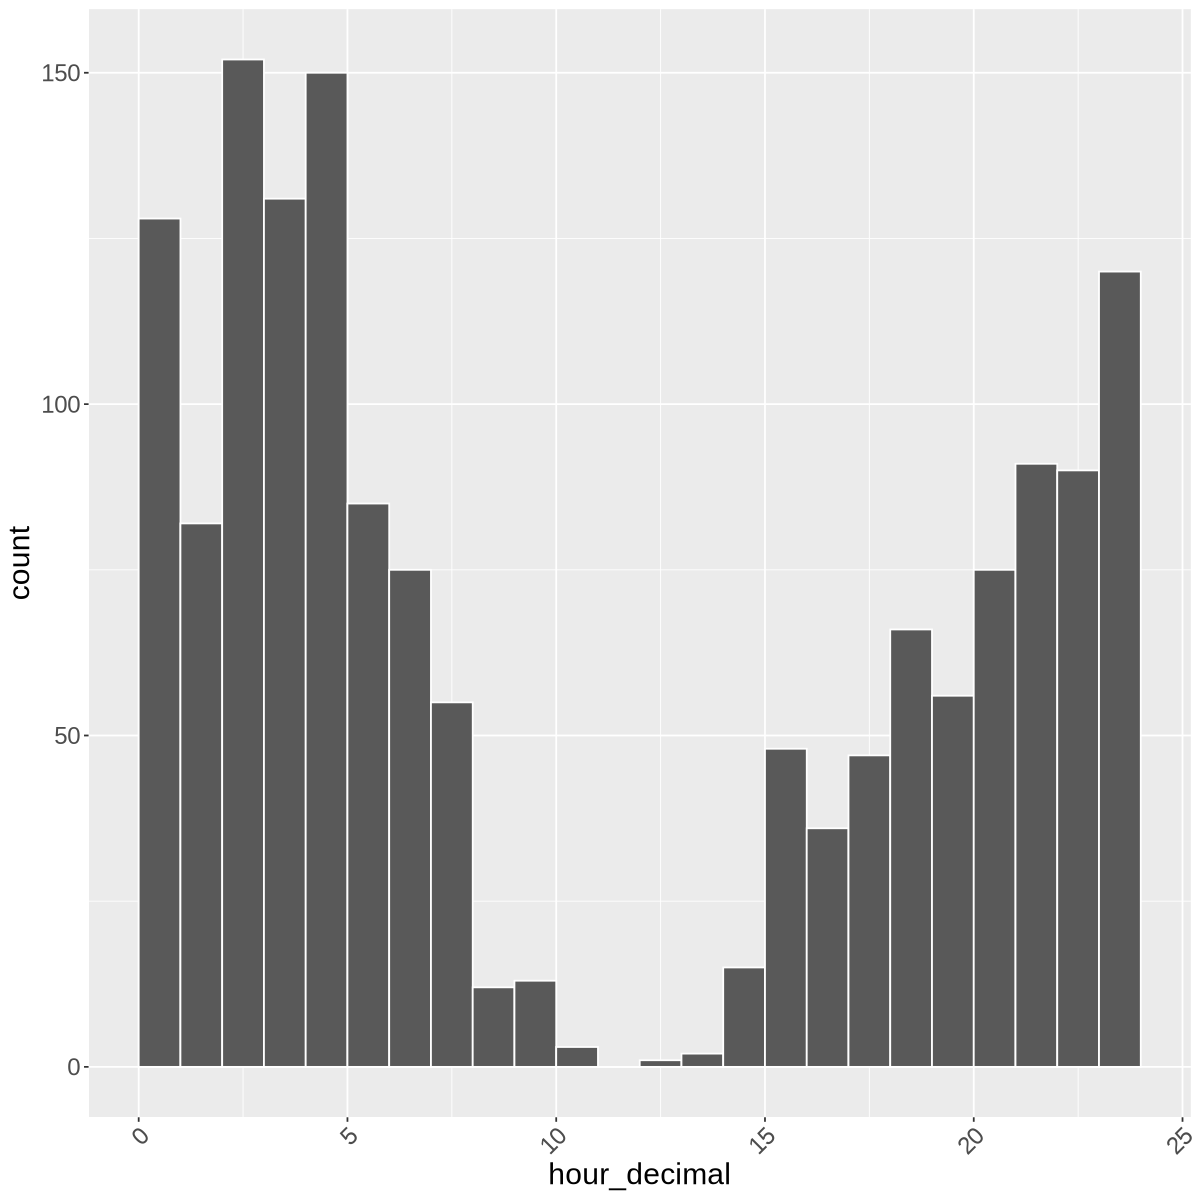

In [25]:
session_start <- na.omit(sessions3) |>
    ggplot(aes(hour_decimal)) +
        geom_histogram(colour = "white", binwidth = 1, boundary = 0) +
        labs() +
        theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5),
             axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_brewer(palette = "Dark2") +
        scale_x_continuous(limits = c(0, 24))
session_start

In [27]:
compare_idk <- 

facet_grid {ggplot2},R Documentation
"rows, cols","A set of variables or expressions quoted by vars() and defining faceting groups on the rows or columns dimension. The variables can be named (the names are passed to labeller). For compatibility with the classic interface, rows can also be a formula with the rows (of the tabular display) on the LHS and the columns (of the tabular display) on the RHS; the dot in the formula is used to indicate there should be no faceting on this dimension (either row or column)."
scales,"Are scales shared across all facets (the default, ""fixed""), or do they vary across rows (""free_x""), columns (""free_y""), or both rows and columns (""free"")?"
space,"If ""fixed"", the default, all panels have the same size. If ""free_y"" their height will be proportional to the length of the y scale; if ""free_x"" their width will be proportional to the length of the x scale; or if ""free"" both height and width will vary. This setting has no effect unless the appropriate scales also vary."
shrink,"If TRUE, will shrink scales to fit output of statistics, not raw data. If FALSE, will be range of raw data before statistical summary."
labeller,"A function that takes one data frame of labels and returns a list or data frame of character vectors. Each input column corresponds to one factor. Thus there will be more than one with vars(cyl, am). Each output column gets displayed as one separate line in the strip label. This function should inherit from the ""labeller"" S3 class for compatibility with labeller(). You can use different labeling functions for different kind of labels, for example use label_parsed() for formatting facet labels. label_value() is used by default, check it for more details and pointers to other options."
as.table,"If TRUE, the default, the facets are laid out like a table with highest values at the bottom-right. If FALSE, the facets are laid out like a plot with the highest value at the top-right."
switch,"By default, the labels are displayed on the top and right of the plot. If ""x"", the top labels will be displayed to the bottom. If ""y"", the right-hand side labels will be displayed to the left. Can also be set to ""both""."
drop,"If TRUE, the default, all factor levels not used in the data will automatically be dropped. If FALSE, all factor levels will be shown, regardless of whether or not they appear in the data."
margins,"Either a logical value or a character vector. Margins are additional facets which contain all the data for each of the possible values of the faceting variables. If FALSE, no additional facets are included (the default). If TRUE, margins are included for all faceting variables. If specified as a character vector, it is the names of variables for which margins are to be created."
axes,"Determines which axes will be drawn. When ""margins"" (default), axes will be drawn at the exterior margins. ""all_x"" and ""all_y"" will draw the respective axes at the interior panels too, whereas ""all"" will draw all axes at all panels."
